# Comparing outcomes of mean simulations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.special import kl_div
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time

/tmp/ipykernel_3581984/1976549207.py:13: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ubuntu/Github/memento/')
import memento
import memento.auxillary.simulate as simulate

In [4]:
data_path = '/home/ubuntu/Data/'

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

### Plotting

In [7]:
def concordance(x, y, log=True):
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [8]:
means = np.load(data_path + 'simulation/mean/simulation_means.npz')['means']
meta = pd.read_csv(data_path + 'simulation/mean/simulation_metadata.csv')
results = meta.iloc[1:].copy()

In [9]:
concordances = []
for i in range(1, means.shape[0]):
    
    c = concordance(means[0], means[i])
    concordances.append(c)
results['concordance'] = concordances

/tmp/ipykernel_3581984/3688686602.py:5: RuntimeWarning: divide by zero encountered in log
  b = np.log(y)


In [10]:
methods_to_show = ['hypergeometric']
q_limit = 0.3
results_to_show = results\
    .query('method in @methods_to_show')\
    .query(f'q < {q_limit}')\
    .sort_values('num_cell', ascending=False)

In [11]:
def plot_curve(x, y, data, ax, marker, color, markersize, linestyle='-'):
    
    agg_data = data.groupby(x)[y].agg(['mean', 'std'])
    x_data = agg_data.index
    y_data = agg_data['mean'].values
    y_err = agg_data['std']*3
    
    ax.plot(x_data, y_data, marker=marker, color=color, markersize=markersize, linestyle=linestyle)
    # ax.errorbar(x_data, y_data, y_err, marker=marker, color=color, markersize=markersize, linestyle=linestyle)

    ax.fill_between(x_data, y_data-y_err, y_data+y_err, alpha=0.4, color=color)

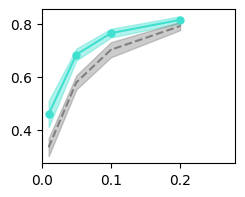

In [12]:
fig, ax = plt.subplots(figsize=(2.5,2))


# plot_curve('q', 'concordance', 
#            data=results\
#             .query('num_cell == 100')\
#             .query('method == "hypergeometric"')\
#             .query(f'q < {q_limit}') ,
#            ax=ax, 
#            color='turquoise',
#            marker='o', 
#            markersize=5)

# plot_curve('q', 'concordance', 
#            data=results\
#             .query('num_cell == 100')\
#             .query('method == "naive"')\
#             .query(f'q < {q_limit}') ,
#            ax=ax, 
#            color='gray', 
#            marker=',', 
#            markersize=5,
#            linestyle='--')

plot_curve('q', 'concordance', 
           data=results\
            .query('num_cell == 10')\
            .query('method == "hypergeometric"')\
            .query(f'q < {q_limit}') ,
           ax=ax, 
           color='turquoise', 
           marker='o', 
           markersize=5)

plot_curve('q', 'concordance', 
           data=results\
            .query('num_cell == 10')\
            .query('method == "naive"')\
            .query(f'q < {q_limit}') ,
           ax=ax, 
           color='gray', 
           marker=',', 
           markersize=5,
           linestyle='--')

plt.xlim(0, 0.28)
plt.savefig('mean_simulation.pdf', bbox_inches='tight')